# Tutorial 4a: Parameter estimation and MLE

*This tutorial was generated from an Jupyter notebook.  You can download the notebook [here](t4a_max_likelihood.ipynb).*

In [247]:
import itertools

# Our numerical workhorses
import numpy as np
import pandas as pd
import scipy.optimize
import scipy.stats as st

# Numerical differentiation packages
import numdifftools as ndt

# Import pyplot for plotting
import matplotlib.pyplot as plt

# Seaborn, useful for graphics
import seaborn as sns

# Magic function to make matplotlib inline; other style specs must come AFTER
%matplotlib inline

# This enables high res graphics inline (only use with static plots (non-Bokeh))
# SVG is preferred, but there is a bug in Jupyter with vertical lines
%config InlineBackend.figure_formats = {'png', 'retina'}

# JB's favorite Seaborn settings for notebooks
rc = {'lines.linewidth': 2, 
      'axes.labelsize': 18, 
      'axes.titlesize': 18, 
      'axes.facecolor': 'DFDFE5'}
sns.set_context('notebook', rc=rc)
sns.set_style('darkgrid', rc=rc)

In this tutorial, we will expand our practice of parameter estimation to non-Gaussian likelihoods.  In fact, we have already done this in [Tutorial 3b](t3b_boolean_data.html), where we consider a binomial likelihood.  We will see here that there are really no difference in the principles, but there are some subtleties in how we find the MAP.

The term "MLE" is also in the title of this tutorial.  Maximum likelihood estimation is the procedure for finding the parameters that maximize the likelihood.  This is a special case in the Bayesian framework: it is the MAP for a uniform prior.  The term is widely used, and we show here that it is as simple as what we have already done: it's just MAP finding.

In the process of this tutorial, we will explore more of the powerful functionality of the `scipy.stats` module, as we use it in our posterior definitions and also for sampling out of distributions.

## The data set

The data come from the [Elowitz lab](http://elowitz.caltech.edu/), published in Singer et al., Dynamic Heterogeneity and DNA Methylation in Embryonic Stem Cells, *Molec. Cell*, **55**, 319-331, 2014, available for download [here](http://bebi103.caltech.edu/2015/protected/papers/singer_2014.pdf).

In this paper, the authors investigated cell populations of embryonic stem cells using RNA single molecule fluorescence in situ hybridization (smFISH), a technique that enables them to count the number of mRNA transcripts in a cell for a given gene.  They were able to measure four different genes in the same cells.  So, for one experiment, they get the counts of four different genes in a collection of cells.  

The authors focused on genes that code for pluripotency-associated regulators to study cell differentiation.  Indeed, differing gene expression levels are a hallmark of differentiated cells.  The authors do not just look at counts in a given cell at a given time.  The *temporal* nature of gene expression is also important.  While the authors do not directly look at temporal data using smFISH (since the technique requires fixing the cells), they did look at time lapse fluorescence movies of other regulators.  We will not focus on these experiments here, but will discuss how the distribution of mRNA counts acquired via smFISH can serve to provide some insight about the dynamics of gene expression.

The data set we are analyzing now comes from an experiment where smFISH was performed in 279 cells for the genes *rex1*, *rest*, *nanog*, and *prdm14*.  The data set may be downloaded [here](http://bebi103.caltech.edu/2015/data/singer_transcript_counts.csv).

### Histograms of mRNA counts
Let's go ahead and explore the data.  We will load in the data set and generate histograms and ECDFs for the mRNA counts for each of the four genes. 

In [2]:
# Load DataFrame
df = pd.read_csv('../data/singer_et_al/singer_transcript_counts.csv',
                comment='#')

# Take a look
df.head()

,Rex1,Rest,Nanog,Prdm14
0,11,34,39,0
1,172,91,33,5
2,261,70,68,0
3,178,54,88,1
4,129,54,41,0


The data are already tidy, since each row is a single measurement (a single cell).  We can plot histograms of all sequences.  We'll do it quick-and-dirty with the `hist()` method that is built in to Pandas `DataFrame`s.

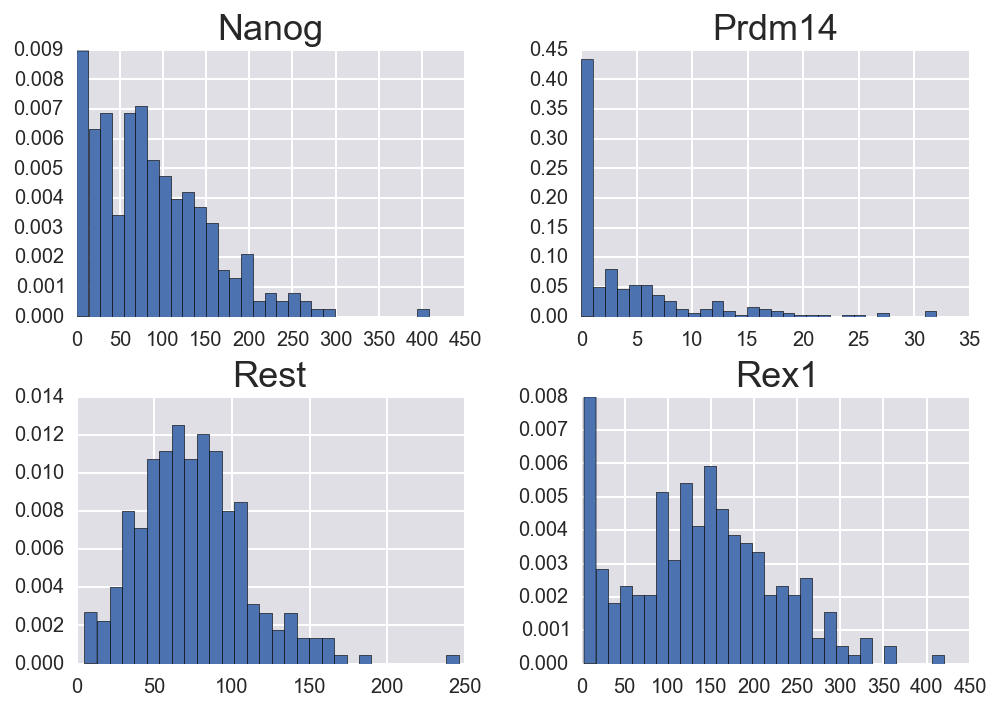

In [23]:
_ = df.hist(normed=True, bins=30)

Note the difference in the $x$-axis scales.  Clearly, *prdm14* has far fewer mRNA copies than the other genes.  Note also that the *rex1* expression seems to be bimodal, which we will discuss momentarily.

We'll also quickly do the ECDFs.

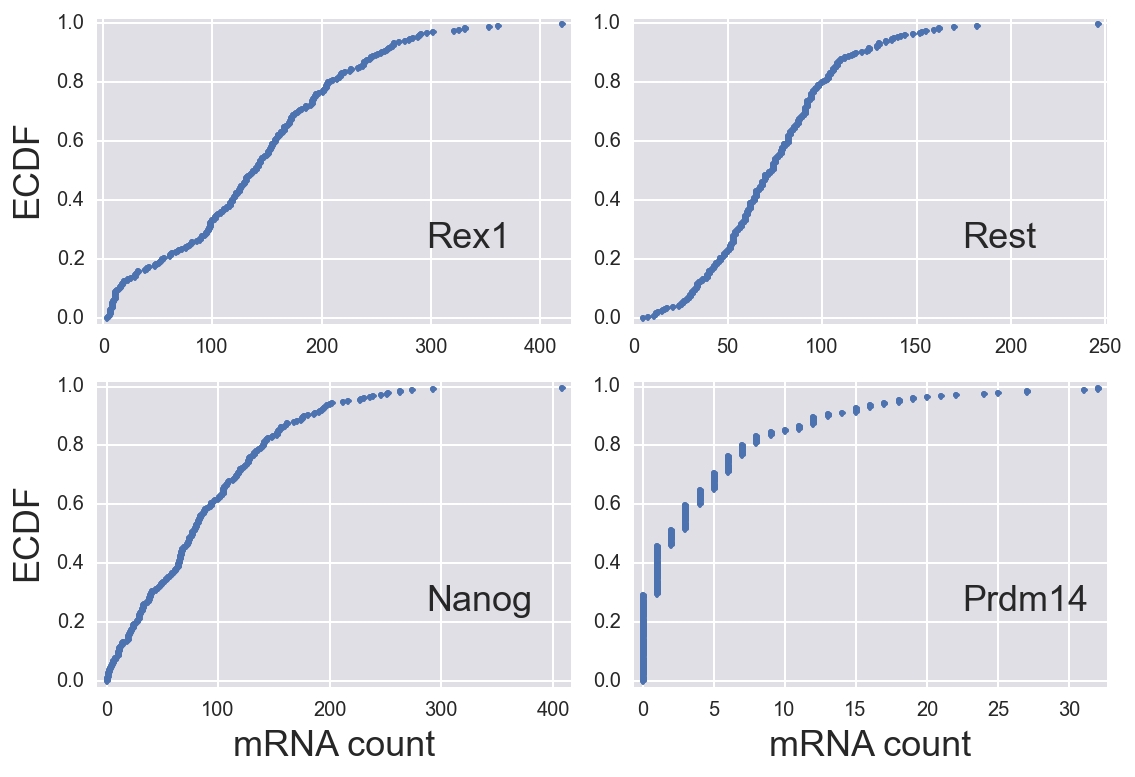

In [226]:
fig, ax = plt.subplots(2, 2)
sp_inds = list(itertools.product([0,1], [0,1]))

for i, gene in enumerate(df.columns):
    # Build ECDF
    y = np.arange(len(df[gene])) / len(df[gene])
    x = np.sort(df[gene].values)
    
    # Plot
    ax[sp_inds[i]].plot(x, y, '.')
    ax[sp_inds[i]].text(0.7, 0.25, gene, transform=ax[sp_inds[i]].transAxes,
                       fontsize=18)
    ax[sp_inds[i]].margins(0.02)
    
# Clean up
for i in [0,1]:
    ax[1,i].set_xlabel('mRNA count')
    ax[i,0].set_ylabel('ECDF')
plt.tight_layout()

The presence of two inflection points in the Rex1 EDCF implies bimodality.  The others seem to be well-described by the negative binomial distribution.

### The distribution of transcript counts and the "story"
The smFISH experiments give the number of mRNA copies of a given gene in a given cell.  How would we expect these numbers to be distributed?

If gene expression is a purely Poisson process, we might expect an exponential distribution.  Or, if the copy number is itself somehow tightly regulated, we might expect a Gaussian distribution.

Study of gene expression dynamics, largely through fluorescence imaging, has lead to a different story.  Expression of many important genes can be **bursty**, which means that the promoter is on for a period of time in which transcripts are made, and then it is off for a while.  The "on" periods are called "bursts" and are themselves well-modeled as a Poisson process.  That is to say that the amount of time that a promoter is on is exponentially distributed.  Thus, we can think of a burst as a series of Bernoulli trials.  A "failure" is production of an mRNA molecule, and a "success" is a switch to an off state.  The number of "successes" we get is equal to the number of bursts we get per decay time of the mRNA.  So, we can define the number of bursts before degradation of the mRNA as $r$.  The so-called **burst frequency** is $1/r$.  So, we have a series of Bernoulli trials and we wait for $r$ successes.  Then, $n$, the total number of failures (which is the number of mRNA transcripts), is negative binomially distributed, since this matches the negative binomial story.  Defining the probability of "success" (ending a burst) as $p$, we have

\begin{align}
P(n\mid r,p) = \frac{(n + r - 1)!}{n!(r-1)!}\,p^r(1-p)^n.
\end{align}

The quantity $p$ is a little mystical here.  We would like to relate it to the typical **burst size**, i.e., the typical number of transcripts made per burst.  A single given burst is geometrically distributed (since it matches that story), so

\begin{align}
P(n_\mathrm{burst}\mid p) = (1-p)^{n_\mathrm{burst}}p.
\end{align}

The mean number of transcripts in a burst is

\begin{align}
b \equiv \left\langle n_\mathrm{burst}\right\rangle &= \sum_{n_\mathrm{burst}=0}^\infty
n_\mathrm{burst}(1-p)^{n_\mathrm{burst}}p\\[1em]
&= p \sum_{n_\mathrm{burst}=0}^\infty
n_\mathrm{burst}(1-p)^{n_\mathrm{burst}} \\[1em]
&= p(1-p)\, \frac{\mathrm{d}}{\mathrm{d}(1-p)}\sum_{n_\mathrm{burst}=0}^\infty(1-p)^{n_\mathrm{burst}} \\[1em]
&= p(1-p)\, \frac{\mathrm{d}}{\mathrm{d}(1-p)}\,\frac{1}{p}\\[1em]
&= -p(1-p)\, \frac{\mathrm{d}}{\mathrm{d}p}\,\frac{1}{p} \\[1em]
&= \frac{1-p}{p}.
\end{align}

So, if we determine $p$ and $r$, we can compute the typical burst size, $b = p/(1-p)$, and the burst frequency, $1/r$.

### Bimodal distributions and their story
As we saw when we explored the data, the distribution in mRNA copies for some genes is clearly bimodal.  Since the negative binomial distribution is unimodal, what could be the story here?  It is quite possible we are seeing two different states of cells, one with one level of bursty expression of the gene of interest, and another with a different level of bursty expression.  This is clearly of interest, since it could mean the cells are differentiating.  So, we would expect the number of mRNA transcripts to be distributed according to a linear combination of negative binomial distributions.

\begin{align}
P(n\mid r_1, r_2, p_1, p_2, f) &= 
f\,\frac{(n + r_1 - 1)!}{n!\,(r_1-1)!}\,p_1^{r_1}(1-p_1)^{n} \\[1em]
&\;\;\;\;+ (1-f) \frac{(n + r_2 - 1)!}{n!\,(r_2-1)!}\,p_2^{r_2}(1-p_2)^{n},
\end{align}

where $f$ is the probability that the burst size and frequency are determined by $p_1$ and $r_1$.

## Parameter estimation for negative binomial distributions

The procedure for parameter estimation for a given gene starts at a familiar place.  We write Bayes's theorem.  We will denote by $\mathbf{n}$ the set of mRNA transcript counts (i.e., $D = \mathbf{n}$).  (We often define $n \equiv |D|$, which we are *not* doing here, so don't get confused.)  Then, Bayes's theorem reads

\begin{align}
P(r, p \mid \mathbf{n}, I) = \frac{P(\mathrm{n}\mid r, p)\,P(r, p \mid I)}{P(D\mid I)},
\end{align}

where the likelihood is a negative binomial distribution, assuming each cell is independent of all others,

\begin{align}
P(\mathrm{n}\mid r, p) = \prod_{n\in\mathbf{n}} \frac{(n + r - 1)!}{n!(r-1)!}\,p^r(1-p)^n.
\end{align}

We now need to specify the prior, $P(r,p\mid I)$.  Specifying a Jeffreys prior (given by the square root of the determinant of the Fisher information matrix) is difficult to do analytically for the negative binomial distribution and therefore requires numerical calculation.  We could implement this, but to illustrate that it is unimportant, we'll consider the prior for $p$ for *a specific $r$*.  In this case, we can derive that $P(p\mid I) \propto 1/(p\sqrt{1-p})$.  Now, the log likelihood contributes

\begin{align}
|D|r\ln p +\left(\sum_{n\in\mathbf{n}}n\right) \ln (1-p)
\end{align}

to the log posterior, whereas our illustrative Jefferys prior contributes $-\ln p - \ln(1-p)/2$.  So, if $|D|$ is large, the contribution from the illustrative Jefferys prior is negligible.
 
For simplicity, we will assume that $r$ and $p$ are independent and assign uniform priors for both $r$ and $p$ (on $[0,\infty)$ for the former and on $[0,1]$ for the latter).  When we have uniform priors on the parameters, the procedure of finding the MAP is then called **maximum likelihood estimation** for the obvious reason that the posterior is proportional to the expression for the likelihood.

Our goal is to find the MAP, or

\begin{align}
\arg \max_{r,p} \sum_{n\in\mathbf{n}} \ln\left(\frac{(n + r - 1)!}{n!(r-1)!}\,p^r(1-p)^n\right).
\end{align}

We will use numerical optimization to achieve this, but there is a wrinkle: we cannot use `scipy.optimize.leastsq()`.

### Numerical optimization to find the MAP
When our likelihood was Gaussian, as was the case with our regression analyses, we could take advantage of the Levenberg-Marquardt algorithm because we were trying to find the minimum of the sum of squares.  Our log posterior here is not of that form, so we need to use other methods.  Fortunately, `scipy.optimize.minimize()` offers many options.  These functions find *minimizers*, so we need to define our objective function as the negative log posterior.

In [205]:
def log_posterior(params, n):
    """
    Log posterior for MLE of Singer data.
    """
    r, p = params
    
    # Zero probability of having p < 0 or p > 1
    if p < 0 or p > 1:
        return -np.inf
    
    # Zero probability of r < 0
    if r < 0:
        return -np.inf

    return st.nbinom.logpmf(n, r, p).sum()

    
def neg_log_posterior(params, n):
    """
    Negative log posterior for MLE of Singer data.
    """
    return -log_posterior(params, n)

Note that in our definition of the log posterior, we used `scipy.stats` to compute the posterior.  There are many convenient functions available in this module.  In particular, most common distributions are available, and for each, we can compute things like the PMF/PDF, CDF, as well as draw random samples out of the distribution.

Now that we have the log posterior defined, we need to find the MAP.  `scipy.optimize.minimize()` offers many options for algorithms, which you can read about in the [documentation](http://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html).  I find that [Powell's method](https://en.wikipedia.org/wiki/Powell%27s_method) tends to work well.  It does not rely on derivative information, so discontinuities don't hurt.  That is important for the present example because we have hard bounds on $p$.  We could use constrained optimizers such as L-BFGS-B or COBYLA, but Powell's method generally suffices.  As a result, though, it is sometimes slow. 

Before implementing the optimization, I'll point out that we are using optimization of continuous variables, but $r$ is discrete in a negative binomial distribution.  Is this ok?  First off, the gamma function is defined for integer and non-integer values, so we are ok in computing our log posterior.  But in principle, is this ok?  In this scenario, $r$ is the typical number of transcripts that are made in the characteristic decay time of mRNA.  It is given by the ratio of the transcript rate and the degradation rate of mRNA.  This is inherently non-integer.  So, allowing $r$ to be continuous is not really a sin, but a feature.  The negative binomial distribution generalizes to noninteger $r$ by replacing the factorials with gamma functions, which is what we do computationally anyhow.

After reading the doc strings, we'll use `scipy.optimize.minimize()` to find the MAP for each gene.

In [153]:
# Give inital guesses
p0 = np.array([5, 0.5])

# Define Hessian function with small initial step size to avoid discontinuity
hes_fun = ndt.Hessian(log_posterior, step=0.001)

# Results
df_MAP = pd.DataFrame(columns=['gene', 'r', 'r_err', 'p', 'p_err', 'b'])

# Do MLE for each gene
for i, gene in enumerate(df.columns):
    # Perform minimization
    res = scipy.optimize.minimize(neg_log_posterior, p0, args=(df[gene],), 
                                  method='powell')
    
    # Compute error bars
    hes = hes_fun(res.x, df[gene])
    cov = -np.linalg.inv(hes)

    # Unpack results
    df_out = pd.DataFrame([[gene, 
                            res.x[0], 
                            np.sqrt(cov[0,0]), 
                            res.x[1], 
                            np.sqrt(cov[1,1]), 
                            (1 - res.x[1]) / res.x[1]]],
                          columns=df_MAP.columns, index=[i])
    df_MAP = df_MAP.append(df_out)
    
# Look at results
df_MAP

,gene,r,r_err,p,p_err,b
0,Rex1,1.632727,0.128773,0.011662,0.001047,84.745113
1,Rest,4.529541,0.399467,0.057003,0.004988,16.542935
2,Nanog,1.263356,0.101061,0.014195,0.001338,69.446285
3,Prdm14,0.552853,0.057854,0.108689,0.013077,8.200553


### The MAP for the bimodal Rex1 distribution
As we noted during exploratory data analysis, the Rex1 distribution appears bimodal.  We will again assume uniform priors on all parameters.  Then, our posterior is

\begin{align}
P(r_1, r_2, p_1, p_2, f\mid n) &\propto 
f\,\frac{(n + r_1 - 1)!}{n!\,(r_1-1)!}\,p_1^{r_1}(1-p_1)^{n} \\[1em]
&\;\;\;\;+ (1-f) \frac{(n + r_2 - 1)!}{n!\,(r_2-1)!}\,p_2^{r_2}(1-p_2)^{n}.
\end{align}

We'll code up the log posterior and again use Powell's method to find the MAP.  We will specify also that $p_1 > p_2$ so the subscripts always refer to the same thing.

In [107]:
def log_posterior_bimodal(params, n):
    """
    Log of posterior for linear combination of neg. binomials.
    """
    r_1, r_2, p_1, p_2, f = params
    
    if (f < 0) or (f > 1):
        return -np.inf
    
    if (r_1 < 0) or (r_2 < 0) or (p_1 < p_2) or (p_2 < 0) or (p_1 > 1):
        return -np.inf
    
    return np.log(f * st.nbinom.pmf(n, r_1, p_1)
                  + (1-f) * st.nbinom.pmf(n, r_2, p_2)).sum()


def neg_log_posterior_bimodal(params, n):
    """
    Negative log posterior for linear combination of neg. binomials.
    """
    return -log_posterior_bimodal(params, n)

Now that the posterior is built, we can perform the optimization.

In [199]:
# Give inital guesses
p0 = np.array([5, 5, 0.3, 0.1, 0.5])

# Define Hessian function with small initial step size to avoid discontinuity
hes_fun = ndt.Hessian(log_posterior_bimodal)

# Perform the optimization
res = scipy.optimize.minimize(neg_log_posterior_bimodal, p0, 
                              args=(df['Rex1'],), method='powell')

# Compute error bars
hes = hes_fun(res.x, df['Rex1'])
cov = -np.linalg.inv(hes)

# Store results in DataFrame
columns = ['r1', 'r1_err', 'r2', 'r2_err', 
           'p1', 'p1_err', 'p2', 'p2_err', 
           'f', 'f_err', 'b1', 'b2']
data = [x[j] for x in list(zip(res.x, np.sqrt(np.diag(cov)))) 
             for j in range(len(x))]
data += [(1 - res.x[2]) / res.x[2], (1 - res.x[3]) / res.x[3]]
df_Rex1_bimodal = pd.DataFrame([data], columns=columns)

# Have a look
df_Rex1_bimodal

,r1,r1_err,r2,r2_err,p1,p1_err,p2,p2_err,f,f_err,b1,b2
0,3.065635,1.141286,5.163311,0.686552,0.170447,0.070746,0.030843,0.003813,0.159909,0.025859,4.866927,31.422723


So, we have managed to measure all of the parameters and their error bars for a bimodal distribution.

## Graphical evaluation of the MLE
To evaluate the MLE, we have several graphical options available.

### Plotting the PMF
As a first option, we can plot the histogram of the counts and overlay the PMF with parameters given by the maximum likelihood estimate.

/Users/Justin/anaconda/lib/python3.4/site-packages/pandas/core/frame.py:1942: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  "DataFrame index.", UserWarning)


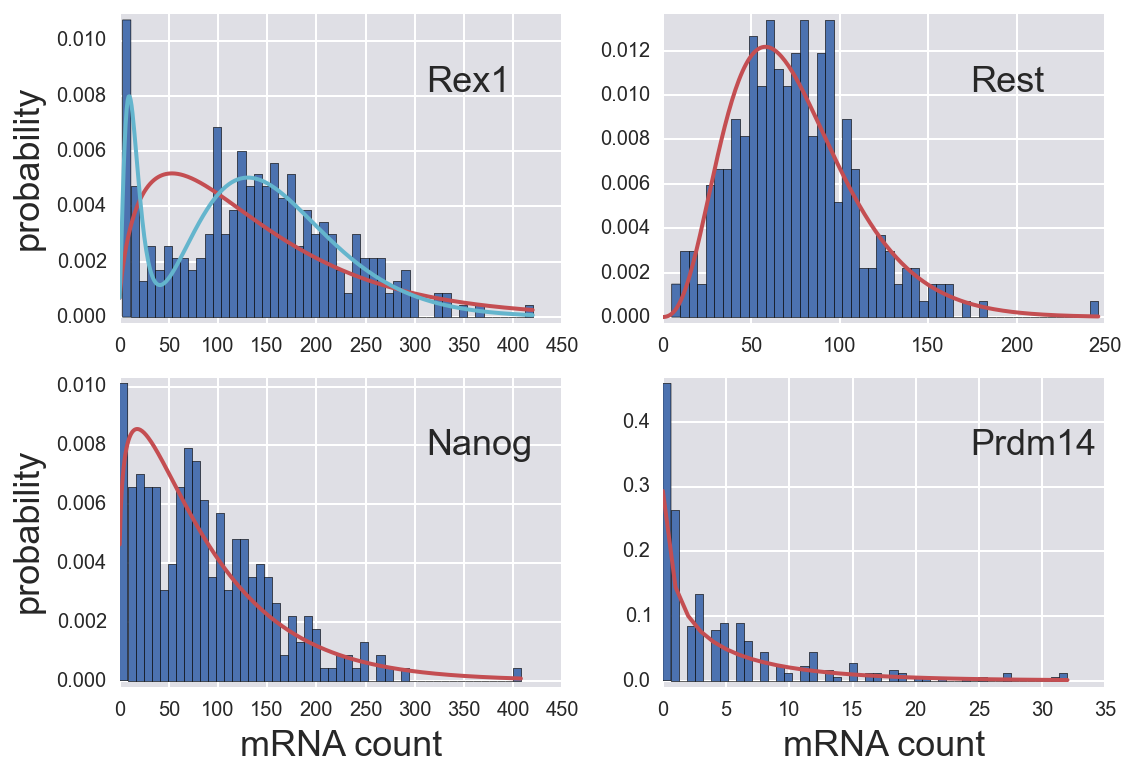

In [237]:
fig, ax = plt.subplots(2, 2)
sp_inds = list(itertools.product([0,1], [0,1]))

for i, gene in enumerate(df.columns):
    # What data to take from MAP DataFrame
    inds = (df_MAP['gene']==gene)
    
    # Build theroetical PMF
    n_plot = np.arange(0, df[gene].max()+1)
    r, p = df_MAP[inds][['r', 'p']].values.flatten()

    # Plot histogram and PMF
    _ = ax[sp_inds[i]].hist(df[gene], bins=50, normed=True)
    ax[sp_inds[i]].plot(n_plot, st.nbinom.pmf(n_plot, r, p), '-', 
                        color=sns.color_palette()[2])
    
    # If it's Rex1, also show the bimodal PMF
    if gene == 'Rex1':
        # Build theroetical PMF
        cols = ['r1', 'r2', 'p1', 'p2', 'f']
        r_1, r_2, p_1, p_2, f = df_Rex1_bimodal[inds][cols].values.flatten()
        pmf = f * st.nbinom.pmf(n_plot,r_1, p_1) +\
                (1-f) * st.nbinom.pmf(n_plot,r_2, p_2)
        ax[sp_inds[i]].plot(n_plot, pmf, '-', color=sns.color_palette()[5])

    # Clean up plot
    ax[sp_inds[i]].text(0.7, 0.75, gene, transform=ax[sp_inds[i]].transAxes,
                        fontsize=18)
    ax[sp_inds[i]].margins(y=0.02)

# Clean up
for i in [0,1]:
    ax[1,i].set_xlabel('mRNA count')
    ax[i,0].set_ylabel('probability')
plt.tight_layout()

While this does show the clearly the deviation from a single negative binomial distribution for Rex1 expression, I tend not to favor this style of plotting because of binning bias.  The next two options I propose are better, in my opinion.

### Plotting the CDF and ECDF
Another (preferred, in my opinion) option is to plot the ECDF with the CDF given by the most probable parameters.

/Users/Justin/anaconda/lib/python3.4/site-packages/pandas/core/frame.py:1942: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  "DataFrame index.", UserWarning)


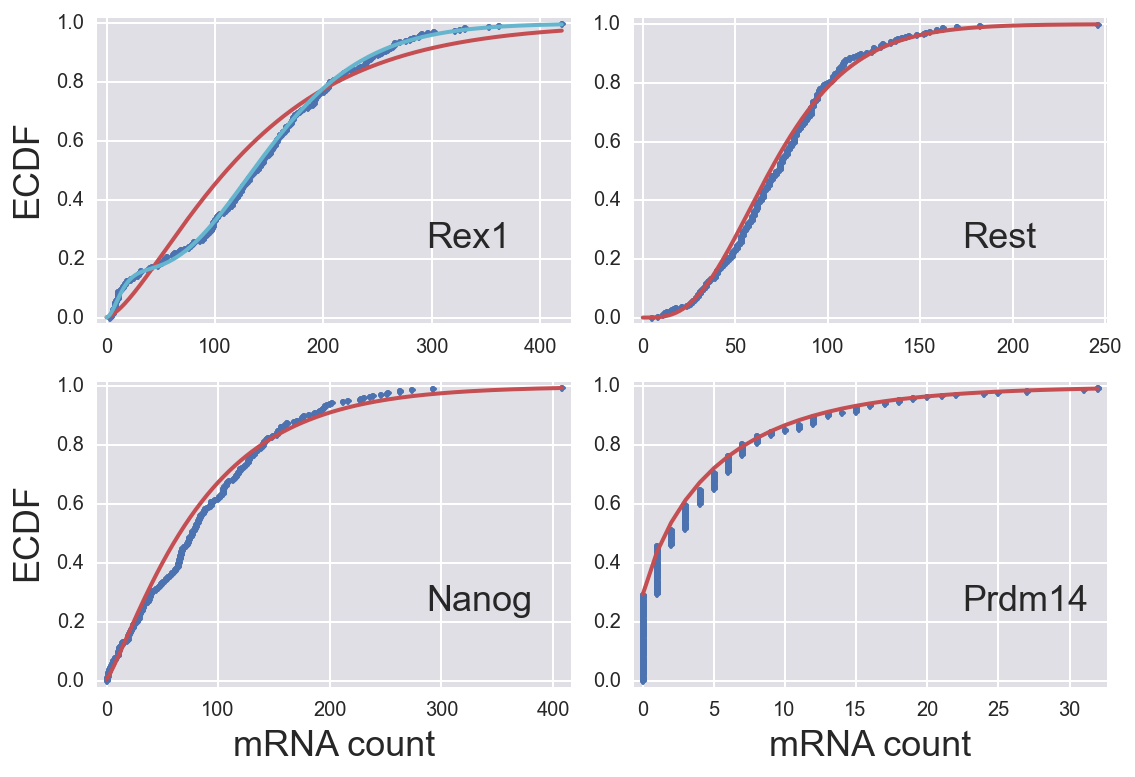

In [239]:
fig, ax = plt.subplots(2, 2)
sp_inds = list(itertools.product([0,1], [0,1]))

for i, gene in enumerate(df.columns):
    # What data to take from MAP DataFrame
    inds = (df_MAP['gene']==gene)
    
    # Build ECDF
    y = np.arange(len(df[gene])) / len(df[gene])
    x = np.sort(df[gene].values)
    
    # Plot
    ax[sp_inds[i]].plot(x, y, '.')
    ax[sp_inds[i]].text(0.7, 0.25, gene, transform=ax[sp_inds[i]].transAxes,
                       fontsize=18)
    ax[sp_inds[i]].margins(0.02)
    
    # Overlay theoretical CDF
    n_plot = np.arange(0, df[gene].max()+1)
    r, p = df_MAP[inds][['r', 'p']].values.flatten()
    ax[sp_inds[i]].plot(n_plot, st.nbinom.cdf(n_plot, r, p), '-',
                        color=sns.color_palette()[2])
    
    # If it is Rex1, do bimodal as well
    if gene == 'Rex1':
        # Build theroetical PMF
        cols = ['r1', 'r2', 'p1', 'p2', 'f']
        r_1, r_2, p_1, p_2, f = df_Rex1_bimodal[inds][cols].values.flatten()
        cdf = f * st.nbinom.cdf(n_plot,r_1, p_1) +\
                (1-f) * st.nbinom.cdf(n_plot,r_2, p_2)
        ax[sp_inds[i]].plot(n_plot, cdf, '-', color=sns.color_palette()[5])
    
# Clean up
for i in [0,1]:
    ax[1,i].set_xlabel('mRNA count')
    ax[i,0].set_ylabel('ECDF')
plt.tight_layout()

This provides a much clearer "by eye" evaluation of the quality of the MAP (and by extension the model) for describing the data.  Our theoretical CDFs for Rex1 and Prdem14 agree very well with the data.  there is a bit of systematic difference in the Nanog and Rest genes.  Especially with Rest, this is more difficult to discern by plotting the histograms.

### Q-Q plots
**Q-Q plots** (the "Q" stands for "quantile) are convenient ways to graphically compare two probability distributions.  In our case, we wish to compare the measured distribution to the theoretical one described by the MAP.  There are many ways to generate Q-Q plots, and many of the descriptions out there are kind of convoluted.  Here is a procedure/description I like for $N$ total empirical samples.

1. Sort your samples from lowest to highest.
2. Draw $N$ samples from the theoretical distribution and sort them.
3. Plot these against each other.

If the plotted fall on a straight line of slope one, the distributions are the same.  Deviations from this highlight differences in the distributions.

I actually like to generate many many sample and them plot the 95% confidence interval region.  This gives a feel of how plausible it is that the observed data were drawn out of the theoretical distribution.

Let's do this with a negative binomial distribution with our measured mRNA transcripts using the MAP to parametrize the theoretical distribution.

/Users/Justin/anaconda/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


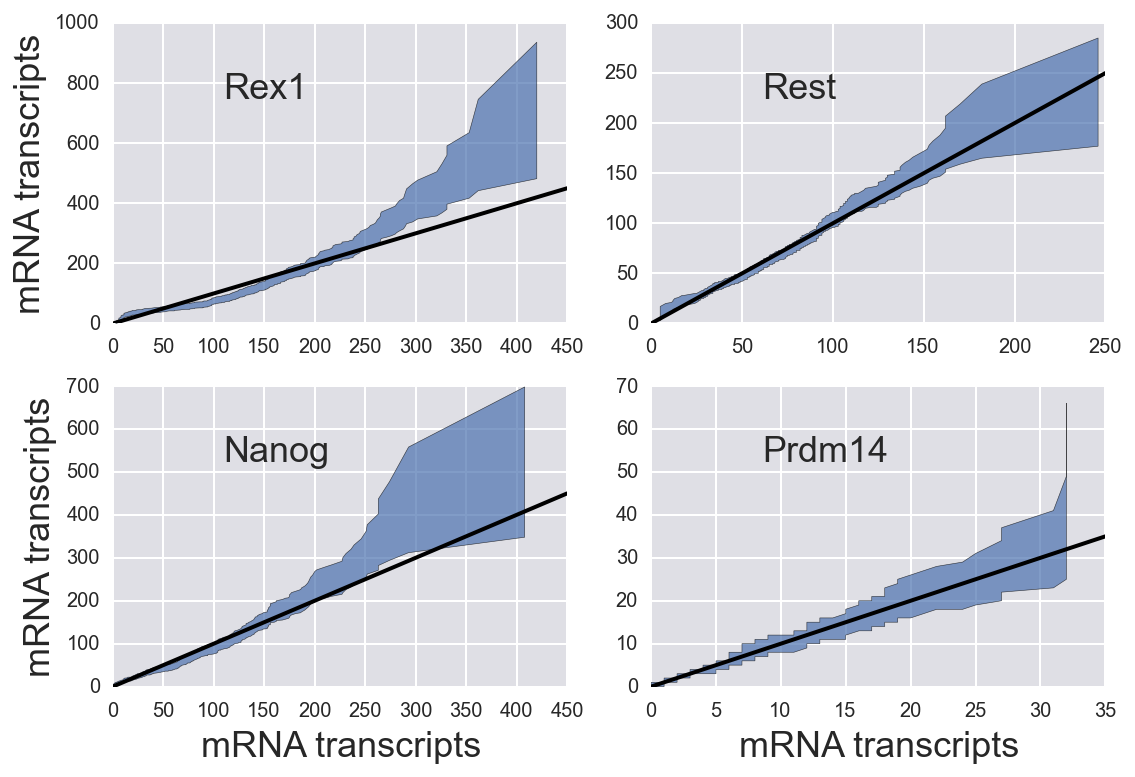

In [249]:
fig, ax = plt.subplots(2, 2)
sp_inds = list(itertools.product([0,1], [0,1]))

for i, gene in enumerate(df.columns):
    # What data to take from MAP DataFrame
    inds = (df_MAP['gene']==gene)

    # Parameters
    r, p = df_MAP[inds][['r', 'p']].values.flatten()

    # x-values
    x = np.sort(df[gene].values)
    
    # Make draws
    theor_x = np.array(
        [np.sort(st.nbinom.rvs(r, p, size=len(x))) for _ in range(1000)])

    # Upper and lower bounds
    low_theor, up_theor = np.percentile(theor_x, (2.5, 97.5), axis=0)

    # Plot Q-Q plots with 95% conf.
    ax[sp_inds[i]].fill_between(x, up_theor, low_theor, alpha=0.7)
    
    # Plot 45 degree line
    x_lim = ax[sp_inds[i]].get_xlim()
    ax[sp_inds[i]].plot(x_lim, x_lim, 'k-')
    
    # Label plot
    ax[sp_inds[i]].text(0.25, 0.75, gene, transform=ax[sp_inds[i]].transAxes,
                       fontsize=18)

# Clean up
for i in [0,1]:
    ax[1,i].set_xlabel('mRNA transcripts')
    ax[i,0].set_ylabel('mRNA transcripts')
plt.tight_layout()

/Users/Justin/anaconda/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


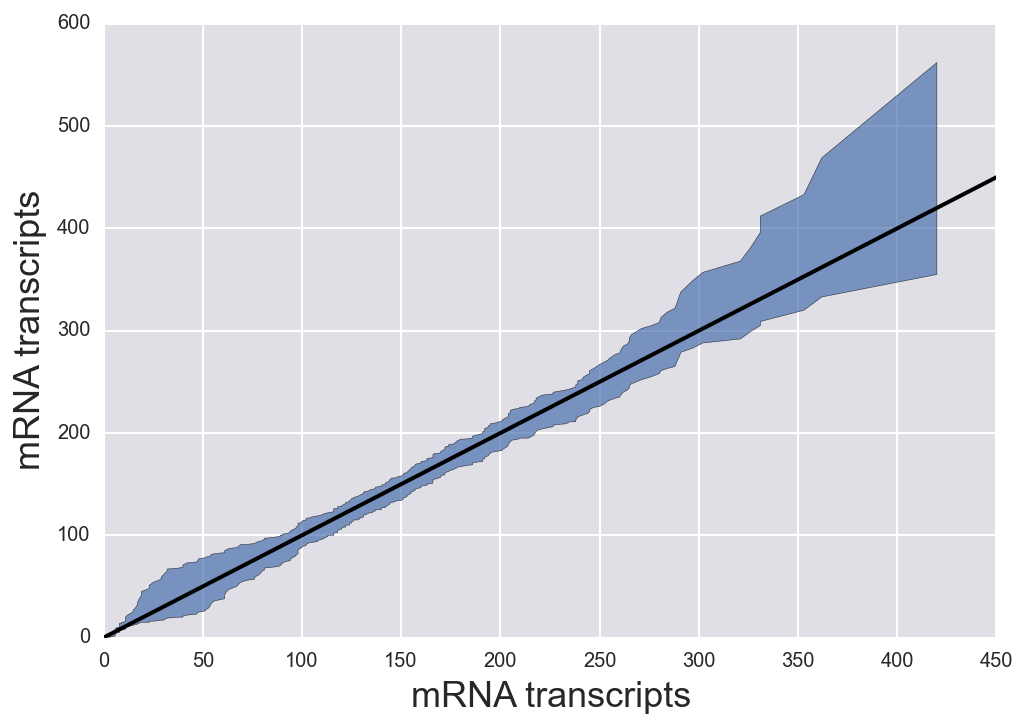

In [268]:
# Pull out parameters
cols = ['r1', 'r2', 'p1', 'p2', 'f']
r1, r2, p1, p2, f = df_Rex1_bimodal[cols].values.flatten()

# x-values
x = np.sort(df['Rex1'].values)

# Make draws
def draw_double_neg_binom(r1, r2, p1, p2, f, size=1):
    """
    Draw from double negative binomial
    """
    fr = st.bernoulli.rvs(f, size=size)
    return fr * st.nbinom.rvs(r1, p1, size=size) + \
            (1-fr) * st.nbinom.rvs(r2, p2, size=size)
    
    
theor_x = np.array(
    [np.sort(draw_double_neg_binom(r1, r2, p1, p2, f, size=len(x)))
                     for _ in range(1000)])

# Upper and lower bounds
low_theor, up_theor = np.percentile(theor_x, (2.5, 97.5), axis=0)

# Plot Q-Q plots with 95% conf.
plt.fill_between(x, up_theor, low_theor, alpha=0.7)

# Plot 45 degree line
x_lim = plt.gca().get_xlim()
plt.plot(x_lim, x_lim, 'k-')

# Label axes
plt.xlabel('mRNA transcripts')
plt.ylabel('mRNA transcripts')

This indicates that the observed mRNA distribution could certainly come from a double negative binomial distribution.  Whether or not this is more likely than another model is part of the topic of **model selection**, which we will talk about in lecture this week.